In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

transforms = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('/tmp/data', train=True, download=True, 
                               transform=transforms)

test_dataset = datasets.MNIST('./data', train=False, download=True,
                              transform=transforms)

print(torch.backends.mps.is_built())
print(torch.backends.mps.is_available())
device

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting /tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting /tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw

True
True


device(type='mps')

In [3]:
BATCH_SIZE      = 64        # number of data points in each batch
N_EPOCHS        = 10        # times to run the model on complete data
INPUT_DIM       = 28 * 28   # size of each input
HIDDEN_DIM      = 256       # hidden dimension
LATENT_DIM      = 20        # latent vector dimension
lr              = 1e-3      # learning rate

In [4]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
class Encoder(nn.Module):
  ''' This the encoder part of VAE'''

  def __init__(self, input_dim: int, hidden_dim: int, z_dim: int):
    '''
    Args:
      input_dim: A integer indicating the size of input 
        (in case of MNIST 28 * 28).
      hidden_dim: A integer indicating the size of hidden dimension.
      z_dim: A integer indicating the latent dimension.
    '''
    super(Encoder, self).__init__()

    self.z_dim = z_dim
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, hidden_dim), 
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim), 
      nn.ReLU(),
      nn.Linear(hidden_dim, 2*z_dim),
    )

  def forward(self, x: torch.Tensor):
    # x is of shape [batch_size, input_dim]

    hidden = self.encoder(x)
    z_mu, z_logvar = hidden[:, :self.z_dim], hidden[:, self.z_dim:]

    return z_mu, z_logvar

In [6]:
class Decoder(nn.Module):
  ''' This the decoder part of VAE'''

  def __init__(self, z_dim: int, hidden_dim: int, output_dim: int):
    '''
    Args:
        z_dim: A integer indicating the latent size.
        hidden_dim: A integer indicating the size of hidden dimension.
        output_dim: A integer indicating the output dimension 
          (in case of MNIST it is 28 * 28)
    '''
    super(Decoder, self).__init__()

    self.decoder = nn.Sequential(
      nn.Linear(z_dim, hidden_dim), 
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim), 
      nn.ReLU(),
      nn.Linear(hidden_dim, output_dim),
      nn.Sigmoid()
    )

  def forward(self, x: torch.Tensor):
    return self.decoder(x)

# Variational AutoEncoder

\begin{align}
\boldsymbol{\mu}_x, \boldsymbol{\sigma}_x &= M(\textbf{x}), \Sigma(\textbf{x}) && \text{Push $\textbf{x}$ through encoder}
\\ \\
\boldsymbol{\epsilon} &\sim \mathcal{N}(0, 1) && \text{Sample noise}
\\ \\
\textbf{z} &= \boldsymbol{\epsilon} \boldsymbol{\sigma}_x + \boldsymbol{\mu}_x  && \text{Reparameterize}
\\ \\
\textbf{x}_r &= p_{\boldsymbol{\theta}}(\textbf{x} \mid \textbf{z}) && \text{Push $\textbf{z}$ through decoder}
\end{align}

In [7]:
class VAE(nn.Module):
  ''' This the VAE, which takes a encoder and decoder.'''

  def __init__(self, enc: Encoder, dec: Decoder):
    super(VAE, self).__init__()
    self.enc = enc
    self.dec = dec

  def reparameterization_trick(self, z_mu: torch.Tensor, 
                                z_logvar: torch.Tensor):
  
    # implement reparametrization trick
    return z_mu + torch.exp(z_logvar) * torch.randn_like(z_mu)

  def forward(self, x: torch.Tensor):
    
    # encode
    z_mu, z_logvar = self.enc(x)

    # sample z from posterior distribution
    z_post = self.reparameterization_trick(z_mu, z_logvar)
    
    # decode
    predicted = self.dec(z_post)

    return predicted, z_mu, z_logvar

  def sample(self, num_samples: int = 1):
    
    # implement sampling of num_samples datapoint
    z = torch.randn((num_samples, LATENT_DIM), device=device)
    return self.dec(z)

# ELBO computation

\begin{align}
\text{recon. loss} &= \text{MSE}(\textbf{x}, \textbf{x}_r) \ \ \text{or} \ \  \text{BCE}(\textbf{x}, \textbf{x}_r) && \text{Compute reconstruction loss}
\\ \\
\text{var. loss} &= \text{KL}[\mathcal{N}(\boldsymbol{\mu}_x, \boldsymbol{\sigma}_x) \lVert \mathcal{N}(0, I)] && \text{Compute variational loss}
\\ \\
\text{L} &= \text{recon. loss} + \text{var. loss} && \text{Combine losses}
\end{align}

\\

\begin{aligned}
\text{KL}[\mathcal{N}(\mu_1, \Sigma_1) \lVert \mathcal{N}(\mu_2, \Sigma_2))] &= \\ 
& \frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr} \{ \Sigma_2^{-1}\Sigma_1 \} + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right], \text{where}~~d~~\text{is the number of dimensions}
\end{aligned}

In [8]:
class ELBO(nn.Module):

  def __init__(self):
    super(ELBO, self).__init__()

  def compute_rec_error_(self, x: torch.Tensor, x_rec: torch.Tensor):
    # implement reconstruction error
    return F.binary_cross_entropy(x_rec, x, reduction='sum')
  
  def compute_kl_(sefl, z_mu: torch.Tensor, z_logvar: torch.Tensor):
    # implement kl divergence (see above, think of what you're matching)
    return 0.5 * torch.sum(torch.exp(z_logvar) + z_mu**2 - - 1.0 - z_logvar)

  def forward(self, x: torch.Tensor, x_rec: torch.Tensor, 
              z_mu: torch.Tensor, z_logvar: torch.Tensor): 

    # reconstruction loss
    recon_loss = self.compute_rec_error_(x, x_rec)

    # kl divergence loss
    kl_loss = self.compute_kl_(z_mu, z_logvar)

    # total loss
    loss = recon_loss + kl_loss

    return loss

In [9]:
from torch.utils.data import DataLoader

def eval(data_loader: DataLoader, model: VAE):
    
  # set the evaluation mode
  model.eval()

  # test loss for the data
  test_loss = 0
  num_examples = 0

  # define the ELBO loss function
  loss = ELBO()

  # we don't need to track the gradients, since we are not updating the 
  # parameters during evaluation / testing
  with torch.no_grad():
    for i, (x, _) in enumerate(data_loader):
      # reshape the data
      x = x.view(-1, 28 * 28)
      x = x.to(device)

      # forward pass
      x_rec, z_mu, z_logvar = model(x)

      test_loss += loss(x, x_rec, z_mu, z_logvar).item()
      num_examples += len(x)

  return test_loss/num_examples

In [10]:
encoder   = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM) # encoder
decoder   = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM) # decoder
model     = VAE(encoder, decoder).to(device) # vae
optimizer = optim.Adam(model.parameters(), lr=lr)  # optizer
loss_fun  = ELBO()

for e in range(N_EPOCHS):

  # set the train mode
  model.train()
  
  for i, (x, _) in enumerate(train_iterator):
      
    # reshape the data into [batch_size, 784]
    x = x.view(-1, 28 * 28).to(device)

    # update the gradients to zero
    optimizer.zero_grad()

    # forward pass
    x_rec, z_mu, z_logvar = model(x)

    loss = loss_fun(x, x_rec, z_mu, z_logvar)
    
    # backward pass
    loss.backward()
    
    # update the weights
    optimizer.step()

  print(f'Epoch {e}, Train Loss: {eval(train_iterator, model):.2f}, \
        Test Loss: {eval(test_iterator, model):.2f}')

Epoch 0, Train Loss: 144.27,         Test Loss: 143.31
Epoch 1, Train Loss: 127.61,         Test Loss: 126.79
Epoch 2, Train Loss: 121.16,         Test Loss: 120.44
Epoch 3, Train Loss: 118.16,         Test Loss: 117.59
Epoch 4, Train Loss: 116.94,         Test Loss: 116.60
Epoch 5, Train Loss: 114.98,         Test Loss: 114.77
Epoch 6, Train Loss: 114.13,         Test Loss: 114.01
Epoch 7, Train Loss: 113.36,         Test Loss: 113.37
Epoch 8, Train Loss: 112.36,         Test Loss: 112.54
Epoch 9, Train Loss: 111.80,         Test Loss: 112.03


# Example: sampling

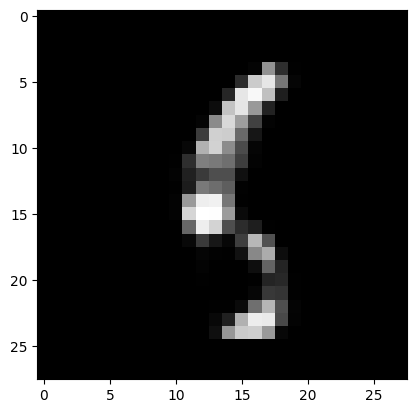

In [11]:
img = model.sample()
img = img.view(28, 28)
img = img.cpu().detach().numpy()

plt.imshow(img, cmap='gray')

# Example: interpolation

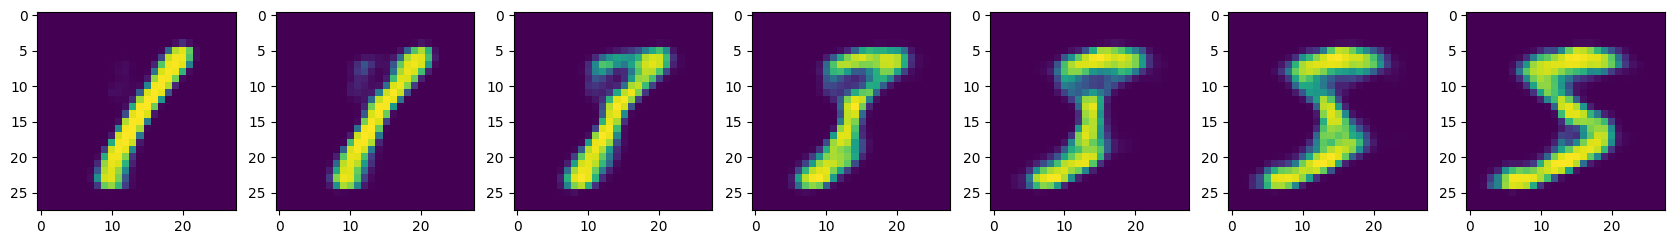

In [12]:
number_one = train_dataset.data[train_dataset.targets == 1][0]
number_five = train_dataset.data[train_dataset.targets == 5][0]

with torch.no_grad():
  one_mu, one_logvar = model.enc((number_one.view(-1, 28 * 28) / 255.).to(device))
  z_one = model.reparameterization_trick(one_mu, one_logvar)
  five_mu, five_logvar = model.enc((number_five.view(-1, 28 * 28) / 255.).to(device))
  z_five = model.reparameterization_trick(five_mu, five_logvar)

  fig, ax = plt.subplots(1, 7, figsize=(21,3))
  for n, i in enumerate(torch.linspace(0, 1, 7)):
    predicted = model.dec(z_five * i + z_one * (1-i)).cpu()
    ax[n].imshow(predicted.view(28,28))